In [1]:
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import f1_score, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')


%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)

In [2]:
X = pd.read_csv('data/features_train.csv')
y = pd.read_csv('data/classes_train.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, shuffle=True)

### 1. Базовый контекст (делают все хоть как-то)

1.1 Обучить модель без каких-либо дополнительных условий, которая должна наилучшим образом отработать на тестовой выборке преподавателя с точки зрения F-меры

In [4]:
# Обучение модели градиентного бустинга без использования гиперпараметров

model = xgb.XGBClassifier()
model.fit(X_train, y_train)
predict = model.predict(X_test)
print(f"XGBoost F1-score without hypertuning: {f1_score(y_test, predict)}")

XGBoost F1-score without hypertuning: 0.9932203389830508


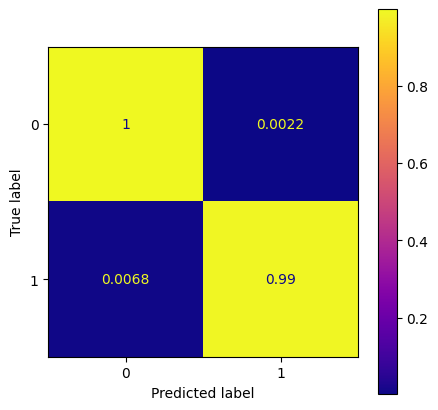

In [5]:
plot_confusion_matrix(model, X_test, y_test, normalize='true', cmap='plasma')

0.68% ботов модель классифицировала как пользователей. Условием лабораторной работы является порог пропуска ботов в 3%, исходя из полученных результатов данная модель выполняет условие задания.

In [6]:
with open('models/xgboost_model.pkl','wb') as f:
    pickle.dump(model, f)

In [7]:
# Подберем гиперпараметры для модели

param_grid = {
    'learning_rate' : [0.05, 0.10, 0.15, 0.20, 0.25],
    'max_depth' : [3, 4, 5, 6, 7],
    'min_child_weight' : [1, 3, 5, 7, 9],
    'gamma': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree' : [0.3, 0.4, 0.5]
}

In [8]:
kfold = KFold(n_splits=10, shuffle=True, random_state=10)
search_params = RandomizedSearchCV(model, param_grid, n_iter=350, cv=kfold)
result = search_params.fit(X_train, y_train)

In [9]:
print(f'Best score: {result.best_score_}')

Best score: 0.9983333333333334


In [10]:
print(f'Best parametrs: {result.best_params_}')

Best parametrs: {'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.3}


In [11]:
# Обучим модель с подобранными гиперпараметрами
params = {'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.3}
model_tuned = xgb.XGBClassifier(**params)
model_tuned.fit(X_train, y_train)
predict = model_tuned.predict(X_test)
print(f"XGBoost F1-score with hypertuning: {f1_score(y_test, predict)}")

XGBoost F1-score with hypertuning: 0.9915110356536503


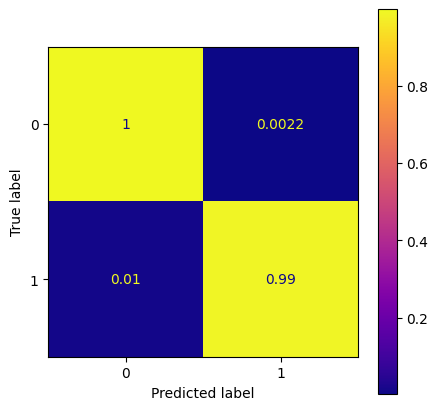

In [12]:
plot_confusion_matrix(model_tuned, X_test, y_test, normalize='true', cmap='plasma')

С подобранными гиперпараметрами модель стала предсказывать немного хуже, 1% ботов модель классифицировала как пользователей. Условием лабораторной работы является порог пропуска ботов в 3%, но исходя из полученных результатов модель с подобранными гиперпараметрами удовлетворяет условию лабораторной работы.

In [13]:
with open('models/xgboost_model_tuned.pkl','wb') as f:
    pickle.dump(model, f)

## 2. Вторичные контесты

2.1. Максимально логичным образом обучить качественную модель, использующую для работы только 10 признаков из всего исходного множества.

In [14]:
# Отбираем 10 признаков с помощью SelectKBest & chi2

from sklearn.feature_selection import SelectKBest, chi2

best_features = SelectKBest(score_func=chi2, k=10)
fit = best_features.fit(X_train, y_train)

best_features_df = pd.DataFrame(data={"feature": X_train.columns, "chi2_score": fit.scores_}, index=None)
best_features_df = best_features_df.sort_values(by="chi2_score", ascending=False).reset_index(drop=True)
best_features_df.head(10)

,feature,chi2_score
0,followers_count,3.003899e+07
1,followers_friends_ratio,4.955864e+06
2,favourites_count,4.137099e+06
3,friends_count,6.895921e+05
4,user_age,3.714542e+05
5,statuses_count,3.481416e+05
6,listed_count,2.435328e+05
7,followers_growth_rate,6.387008e+03
8,favourites_growth_rate,1.055938e+03
9,description_length,7.871024e+02


In [15]:
# создаем новый датафрейм и пробуем обучить модель с отобранными признаками

chi2_df = X[[
    'followers_count', 'followers_friends_ratio', 'favourites_count', 
    'friends_count', 'user_age', 'statuses_count', 'listed_count', 
    'followers_growth_rate', 'favourites_growth_rate', 'description_length'
]]

In [16]:
X_train_chi2, X_test_chi2, y_train_chi2, y_test_chi2 = train_test_split(chi2_df, y, test_size=0.5, random_state=1, shuffle=True)

In [17]:
model = xgb.XGBClassifier()
model.fit(X_train_chi2, y_train_chi2)
predict = model.predict(X_test_chi2)
print(f"XGBoost F1-score with top 10 features: {f1_score(y_test_chi2, predict)}")

XGBoost F1-score with top 10 features: 0.9761092150170648


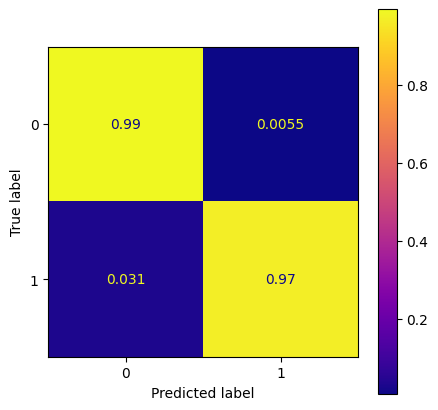

In [18]:
plot_confusion_matrix(model, X_test_chi2, y_test_chi2, normalize='true', cmap='plasma')

Качество модели ухудшилось, 3.1% ботов модель классифицировала как пользователей. Условием лабораторной работы является порог пропуска ботов в 3%, исходя из полученных результатов данная модель не выполняет условие задания.

In [19]:
with open('models/xgboost_model_chi2.pkl','wb') as f:
    pickle.dump(model, f)

In [20]:
# Попробуем обучить модель с подобранными гиперпараметрами с отобранными признакми с помощью chi2
params = {'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.3}
model_tuned = xgb.XGBClassifier(**params)
model_tuned.fit(X_train_chi2, y_train_chi2)
predict = model_tuned.predict(X_test_chi2)
print(f"XGBoost F1-score with hypertuning and top 10 features: {f1_score(y_test_chi2, predict)}")

XGBoost F1-score with hypertuning and top 10 features: 0.9759450171821307


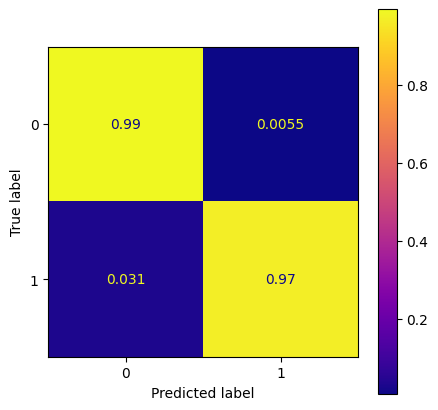

In [21]:
plot_confusion_matrix(model, X_test_chi2, y_test_chi2, normalize='true', cmap='plasma')

Результаты аналогичны модели, которая не имеет гиперпараметров, но с отобранными признаками, такая модель не удовлетворяет условию лабораторной работы.

In [22]:
with open('models/xgboost_model_tuned_chi2.pkl','wb') as f:
    pickle.dump(model, f)

In [24]:
# Отберем признаки с помощью RFE (Recursive Feature Removal)
# Алгоритм жадного поиска, который выбирает признаки, рекурсивно определяя все меньшие наборы признаков, 
# ранжирует признаки в соответствии с порядком их удаления.

from sklearn.feature_selection import RFE

rfe_selector = RFE(estimator=xgb.XGBClassifier(), n_features_to_select=10)
rfe_selector.fit(X_train, y_train)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=None, gpu_id=None,
                            grow_policy=None, importance_type=None,
                            interaction_constraints=None, learning_rate=None,
                            max_bin=None, max_cat_threshold=None,
                            max_cat_to_onehot=None, max_delta_step=None,
                            max_depth=None, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None, predictor=None,
                            random_state=None, ...),
    n_features_to_select=10)

In [26]:
df = pd.DataFrame(rfe_selector.support_, index=X.columns, columns=['Rank'])
# Колонка Rank выдает True или False, если True, то данный признак был отобран, оставим
# в DataFrame только такие признаки
df = df.loc[df['Rank'] == True]
df

,Rank
statuses_count,True
friends_count,True
favourites_count,True
listed_count,True
is_verified,True
user_age,True
tweets_freq,True
listed_growth_rate,True
followers_friends_ratio,True
description_length,True


In [27]:
rfe_df = X[[
    'statuses_count', 'friends_count', 'favourites_count', 
    'listed_count', 'is_verified', 'user_age', 'tweets_freq', 
    'listed_growth_rate', 'followers_friends_ratio', 'description_length'
]]

In [28]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(rfe_df, y, test_size=0.5, random_state=1, shuffle=True)

In [29]:
# Обучаем модель с отобранными признаками с помощью RFE

model = xgb.XGBClassifier()
model.fit(X_train_rfe, y_train_rfe)
predict = model.predict(X_test_rfe)
print(f"XGBoost F1-score with top 10 features: {f1_score(y_test_rfe, predict)}")

XGBoost F1-score with top 10 features: 0.9932203389830508


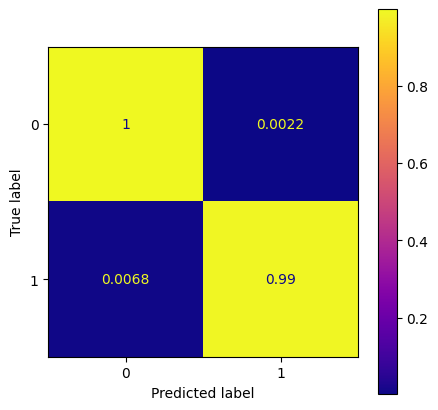

In [30]:
plot_confusion_matrix(model, X_test_rfe, y_test_rfe, normalize='true', cmap='plasma')

Отобранные признаки с помощью RFE оказали более положительное влияние, нежели с помощью chi2

In [31]:
with open('models/xgboost_model_rfe.pkl','wb') as f:
    pickle.dump(model, f)

In [32]:
# Попробуем обучить модель с подобранными гиперпараметрами и отобранными признакми с помощью chi2

params = {'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.3}
model_tuned = xgb.XGBClassifier(**params)
model_tuned.fit(X_train_rfe, y_train_rfe)
predict = model_tuned.predict(X_test_rfe)
print(f"XGBoost F1-score with hypertuning and top 10 features: {f1_score(y_test_rfe, predict)}")

XGBoost F1-score with hypertuning and top 10 features: 0.9932203389830508


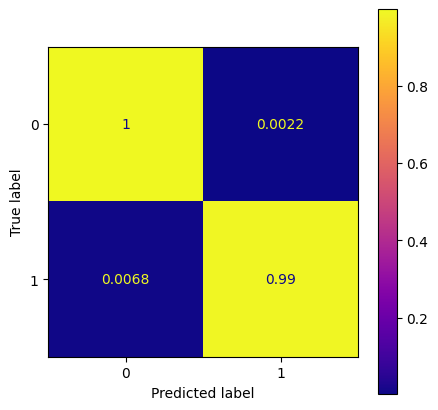

In [33]:
plot_confusion_matrix(model, X_test_rfe, y_test_rfe, normalize='true', cmap='plasma')

Результат аналогичен предыдущем шагу, условие выполнено :)

In [34]:
with open('models/xgboost_model_tuned_rfe.pkl','wb') as f:
    pickle.dump(model, f)

In [42]:
# Попробуем отобрать информативные признаки с помощью регрессии лассо, к тому же она учитывает 
# мультиколлинеарность признаков, если таковые имеются :)
# Указать явное количество мы не сможем, но за количество отобранных признаков отвечает параметр C

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(C=0.01, penalty="l1", solver='liblinear'))
embeded_lr_selector.fit(X_train, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.01, penalty='l1',
                                             solver='liblinear'))

In [43]:
df = pd.DataFrame(embeded_lr_selector.get_support(), index=X.columns, columns=['Rank'])
# Колонка Rank выдает True или False, если True, то данный признак был отобран, оставим
# в DataFrame только такие признаки
df = df.loc[df['Rank'] == True]
df

,Rank
statuses_count,True
followers_count,True
friends_count,True
favourites_count,True
listed_count,True
user_age,True
followers_friends_ratio,True
screen_name_length,True
length_of_name,True
description_length,True


In [45]:
# Вновь было отобрано 10 признаков, попробуем обучить наш классификатор с такими отобранными признаками

l1_df = X[[
    'statuses_count', 'followers_count', 'friends_count',
    'favourites_count', 'listed_count', 'user_age', 'description_length',
    'followers_friends_ratio', 'screen_name_length', 'length_of_name'
]]

In [46]:
X_train_l1, X_test_l1, y_train_l1, y_test_l1 = train_test_split(l1_df, y, test_size=0.5, random_state=1, shuffle=True)

In [47]:
# Обучаем и смотрим результат 

model = xgb.XGBClassifier()
model.fit(X_train_l1, y_train_l1)
predict = model.predict(X_test_l1)
print(f"XGBoost F1-score with top 10 features: {f1_score(y_test_l1, predict)}")

XGBoost F1-score with top 10 features: 0.9743589743589743


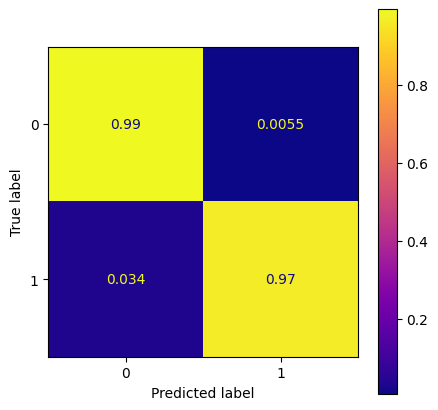

In [48]:
plot_confusion_matrix(model, X_test_l1, y_test_l1, normalize='true', cmap='plasma')

Результат не очень, 3.4% ботов модель классифицировала как пользователей. Условием лабораторной работы является порог пропуска ботов в 3%, исходя из полученных результатов данная модель не выполняет условие задания.

In [49]:
with open('models/xgboost_model_l1.pkl','wb') as f:
    pickle.dump(model, f)

2.2. Обучить модель, обеспечивающую вероятность пропуска бота на уровне не выше 0.03, и имеющую насколько возможно низкую вероятность ложного обнаружения.

In [51]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
model_pred = model.predict(X_test)
print(f"F1-score: {f1_score(y_test, model_pred)}")

F1-score: 0.9932203389830508


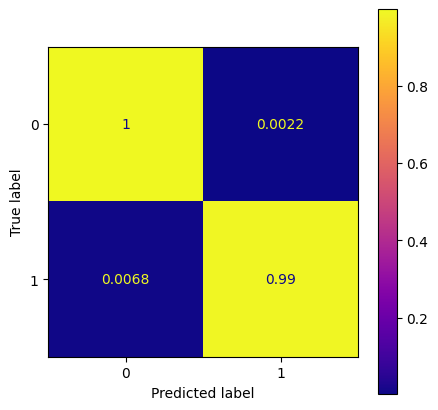

In [52]:
plot_confusion_matrix(model, X_test, y_test, normalize='true', cmap='plasma')

0.68% ботов модель классифицировала как пользователей. Условием лабораторной работы является порог пропуска ботов в 3%, исходя из полученных результатов данная модель выполняет условие задания.

In [53]:
with open('models/model_punkt_2_2.pkl','wb') as f:
    pickle.dump(model, f)

### 3. Углубленное аналитическое исследование по имеющимся данным

3.1. Тем или иным способом выполнить сравнительное исследование значимости различных
признаков применительно к произвольному фиксированному классификатору.

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

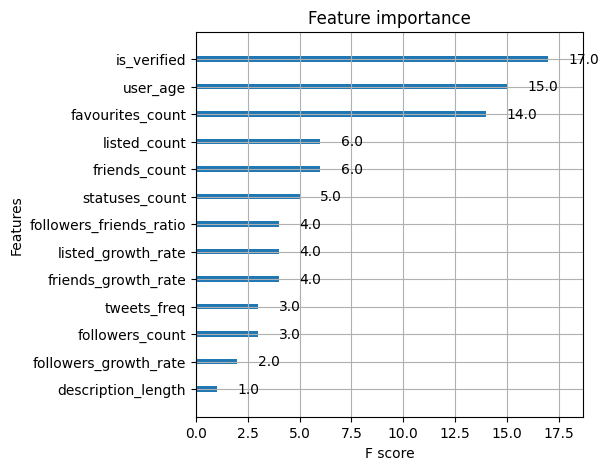

In [54]:
# В XGBoost встроен визуализатор важности фич, можно посмотреть на наиболее важные фичи именно таким образом

xgb.plot_importance(model)

In [63]:
# Так же можно посмотреть важность фич не по всей выборке, а по конкретному объекту, воспользуемся библиотекой shap

import shap

explainer = shap.TreeExplainer(model)
shap_values=explainer.shap_values(X_test, y_test)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[15,:], X.iloc[15,:])

Фичи для объекта выборки 15, а именно is_verified, favourites_count и др., которые мы видим на графике показывают, что пользователь то и не бот :)

3.2. Синтезировать 3 или более собственных признаков на основе имеющихся и показать, что
они имеют какие-либо преимущества перед хотя бы какими либо из базовых признаков.

3.3. Выбрать один базовый тип ML-модели на свой вкус (SVM, дерево решений, случайный
лес, градиентный бустинг и пр.) и провести ROC-анализ в зависимости от её
гиперпараметров.

In [67]:
from sklearn.model_selection import cross_val_score

In [68]:
learning_rate = np.arange(0.1, 3.1, 0.1)
n_estimators = np.arange(101, 201, 1)

  0%|          | 0/30 [00:00<?, ?it/s]

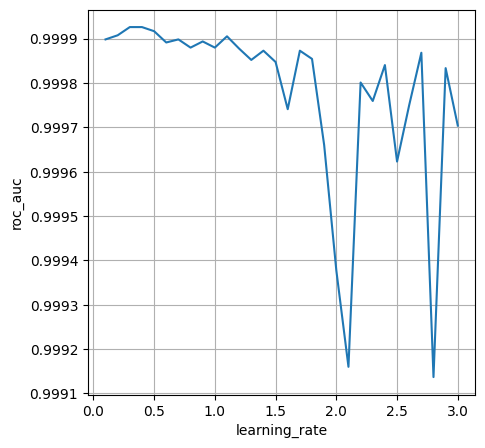

In [69]:
xgb_learning_rate = []

for learn_rate in tqdm(learning_rate):
    model = xgb.XGBClassifier(learning_rate=learn_rate)
    xgb_learning_rate.append(np.mean(cross_val_score(model, X, y, scoring="roc_auc")))
    
learn_rate_df = pd.DataFrame(data={"learning_rate": learning_rate, "roc_auc": xgb_learning_rate})
sns.lineplot(data=learn_rate_df, x="learning_rate", y="roc_auc")
plt.grid()

  0%|          | 0/100 [00:00<?, ?it/s]

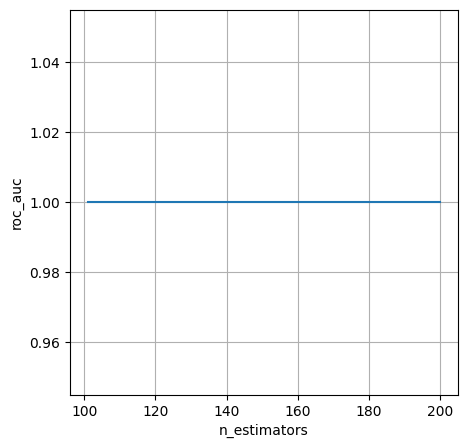

In [70]:
xgb_estimators = []

for estim in tqdm(n_estimators):
    model = xgb.XGBClassifier(n_estimators=estim)
    xgb_estimators.append(np.mean(cross_val_score(model, X, y, scoring="roc_auc")))
    
estim_df = pd.DataFrame(data={"n_estimators": n_estimators, "roc_auc": xgb_estimators})
sns.lineplot(data=estim_df, x="n_estimators", y="roc_auc")
plt.grid()

3.4 Провести исследование влияние параметров обучения на недо- и переобученность
модели.

  0%|          | 0/30 [00:00<?, ?it/s]

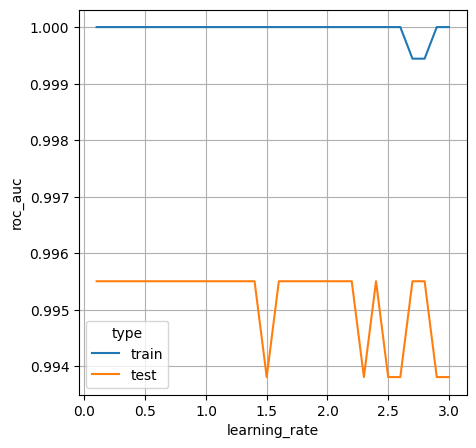

In [71]:
# Возьмем параметр скорости обучения и посмотрим, как он влияет на недо- и переобученность модели

xgb_lr = []

for i in tqdm(learning_rate):
    model = xgb.XGBClassifier(learning_rate=i)
    model.fit(X_train, y_train)

    train_roc_auc = roc_auc_score(y_train, model.predict(X_train))
    xgb_lr.append({"learning_rate": i, "roc_auc": train_roc_auc, "type": "train"})

    test_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    xgb_lr.append({"learning_rate": i, "roc_auc": test_roc_auc, "type": "test"})
    
xgb_lr_df = pd.DataFrame(xgb_lr)
sns.lineplot(data=xgb_lr_df, x="learning_rate", y="roc_auc", hue="type")
plt.grid()

Что можно сказать про скорость обучения? Чем ниже скорость обучения, тем выше качество модели и тем меньше вероятность получить переообучение. Если поставить скорость например 2.5 - 3, то мы быстро получим переобучение модели. Для моделей градиентного бустинга скорость обучения это очень важный параметр